In [20]:
import gzip
from collections import defaultdict
import json
import pandas as pd
import re
import plotly.express as px
import datetime
import random
import seaborn
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
import xlearn as xl

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [4]:
def readJSON(path):
    f = gzip.open(path, 'rt')
    f.readline()

    for l in f:
        yield json.loads(l)

In [5]:
allHawaii = []

for l in readJSON('review-Hawaii_10.json.gz'):
    allHawaii.append(l)

In [6]:
metaHawaii = []

for l in readJSON('meta-Hawaii.json.gz'):
    metaHawaii.append(l)

In [7]:
allHawaii[0]


{'user_id': '116655819137293331166',
 'name': 'Enrique Lara',
 'time': 1568059018979,
 'rating': 5,
 'text': None,
 'pics': None,
 'resp': None,
 'gmap_id': '0x7c00159b5b1b1d25:0x8d2d85d4a758290e'}

In [8]:
metaHawaii[0]

{'name': 'SMP - Single Marine Program',
 'address': 'SMP - Single Marine Program, G St, Kailua, HI 96734',
 'gmap_id': '0x7c00159b5b1b1d25:0x8d2d85d4a758290e',
 'description': None,
 'latitude': 21.440345,
 'longitude': -157.7543475,
 'category': ['Recreation center'],
 'avg_rating': 4.1,
 'num_of_reviews': 18,
 'price': None,
 'hours': [['Thursday', '8AM–9PM'],
  ['Friday', '8AM–9PM'],
  ['Saturday', '11AM–6PM'],
  ['Sunday', '11AM–6PM'],
  ['Monday', '8AM–9PM'],
  ['Tuesday', '8AM–9PM'],
  ['Wednesday', '8AM–9PM']],
 'MISC': {'Accessibility': ['Wheelchair accessible entrance']},
 'state': 'Opens soon ⋅ 8AM',
 'relative_results': ['0x7c00155df23846af:0xfbe051d208292028',
  '0x7c00155a16e34d6b:0xdfff710df652b37b',
  '0x7c006e7572520a81:0x1e4333f8d6ba055f',
  '0x7c006b48d2c27603:0x69b60ab9b6c39621',
  '0x7c0066731ef77ed3:0x23b994cbf456c8d'],
 'url': 'https://www.google.com/maps/place//data=!4m2!3m1!1s0x7c00159b5b1b1d25:0x8d2d85d4a758290e?authuser=-1&hl=en&gl=us'}

In [9]:
random.seed(42)
random.shuffle(allHawaii)
len(allHawaii)

1504346

In [10]:
def zipcode(m):
    address = m['address']
    
    if address == None:
        
        return None
    
    zipcode = re.search(r'.*, HI ([0-9]{5})', m['address'])

    if zipcode == None:
        
        return None
    
    return zipcode.group(1)

def city(m):
    address = m['address']
    
    if address == None:
        
        return None
    
    city = re.search(r', ([^,]*), HI [0-9]{5}$', m['address'])

    if city == None:
        
        return None
    
    return city.group(1)

In [11]:
def createDataFrameDict(m):
    metaDict = {}

    metaDict['name'] = m['name']
    metaDict['gmap_id'] = m['gmap_id']
    metaDict['zipcode'] = zipcode(m)
    metaDict['city'] = city(m)
    metaDict['latitude'] = m['latitude']
    metaDict['longitude'] = m['longitude']
    metaDict['avg_rating'] = m['avg_rating']
    metaDict['num_of_reviews'] = m['num_of_reviews']
    metaDict['price'] = m['price']

    return metaDict

mdf = pd.DataFrame([createDataFrameDict(m) for m in metaHawaii])\
.drop_duplicates()
mdf.head(5)

,name,gmap_id,zipcode,city,latitude,longitude,avg_rating,num_of_reviews,price
0,SMP - Single Marine Program,0x7c00159b5b1b1d25:0x8d2d85d4a758290e,96734,Kailua,21.440345,-157.754347,4.1,18,None
1,2 Cheesy Guys,0x7954d376a8b12db3:0xa51dd57e1cc14ca9,96793,Wailuku,20.853014,-156.503671,5.0,6,None
2,Kraken Coffee Kahului,0x7954d370921ff6bd:0x3193ba783e26d032,96732,Kahului,20.888238,-156.450614,4.8,8,$
3,Akasatana Ramen Kyoto,0x7c006df045b01715:0xe945c308688e1a46,96814,Honolulu,21.290463,-157.843730,5.0,1,None
4,Oahu Osteopathic Clinic,0x7c006de89f2d86e1:0x23d998532e9317a6,96814,Honolulu,21.300483,-157.844839,4.6,8,None


In [12]:
df = pd.DataFrame(allHawaii)[['user_id', 'time', 'rating', 'gmap_id']]
df['time'] = df['time'].apply(lambda x: 
datetime.datetime.fromtimestamp(int(x / 1000)))
df['year'] = df['time'].apply(lambda x: x.year + (x.month / 12))
df.head(5)

,user_id,time,rating,gmap_id,year
0,106764461897322115085,2019-05-10 19:27:10,5,0x7954daa313aaaaab:0xa88048dea2194382,2019.416667
1,100914435758882584947,2018-09-17 16:38:50,5,0x7c006de8a5db938d:0x65d130459fa31dbe,2018.750000
2,109063181648072020556,2019-05-22 12:09:41,3,0x7c006df3515d2d9d:0x747cc48ce1197b73,2019.416667
3,107148966697850192091,2018-05-22 11:21:38,4,0x7c007276fd5577f3:0xb12f0e619b87d5fc,2018.416667
4,102176802458707610649,2019-06-01 20:29:12,5,0x7953d0f20dc87be1:0xed39a9066d9b953d,2019.500000


In [13]:
hawaiiDataFrame = pd.merge(df, mdf, on='gmap_id', how='inner')
hawaiiDataFrame.head(5)

,user_id,time,rating,gmap_id,year,name,zipcode,city,latitude,longitude,avg_rating,num_of_reviews,price
0,106764461897322115085,2019-05-10 19:27:10,5,0x7954daa313aaaaab:0xa88048dea2194382,2019.416667,Kamaole Beach Park II,96753,Kihei,20.716247,-156.44668,4.7,797,None
1,101581248773939616636,2020-02-17 20:30:13,5,0x7954daa313aaaaab:0xa88048dea2194382,2020.166667,Kamaole Beach Park II,96753,Kihei,20.716247,-156.44668,4.7,797,None
2,113350453324004842458,2018-02-21 14:17:46,5,0x7954daa313aaaaab:0xa88048dea2194382,2018.166667,Kamaole Beach Park II,96753,Kihei,20.716247,-156.44668,4.7,797,None
3,106572596243290945955,2019-03-15 17:07:52,5,0x7954daa313aaaaab:0xa88048dea2194382,2019.250000,Kamaole Beach Park II,96753,Kihei,20.716247,-156.44668,4.7,797,None
4,108849671891685327152,2019-11-19 21:08:40,5,0x7954daa313aaaaab:0xa88048dea2194382,2019.916667,Kamaole Beach Park II,96753,Kihei,20.716247,-156.44668,4.7,797,None


In [14]:
fig = px.density_mapbox(mdf, lat = 'latitude', lon = 'longitude', 
radius = 1, center = dict(lat = 20.6, lon = -157.5), zoom = 5.5, 
mapbox_style = 'open-street-map', title='Density Map of Businesses')

fig.show()

In [ ]:
hawaiiDataFrame.plot(kind='scatter')

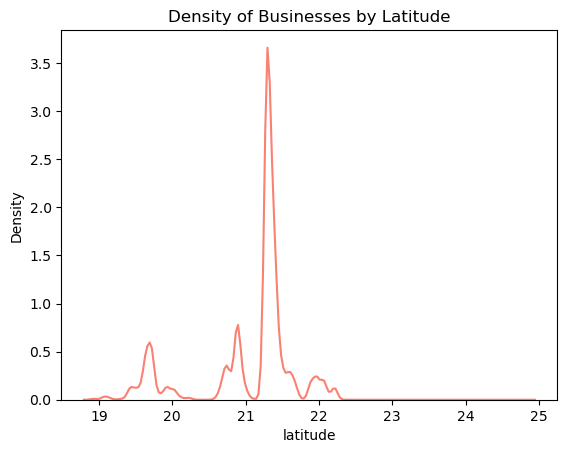

In [19]:
fig = seaborn.kdeplot(x=hawaiiDataFrame['latitude'], color='salmon')\
.set(title='Density of Businesses by Latitude')

In [22]:
topCities = hawaiiDataFrame[['city', 'name']].groupby('city').count()\
.sort_values(by='name', ascending=False).head(15)

fig = px.bar(topCities, title='Top 15 Cities by Number of Reviews', 
color_discrete_sequence=['palegreen'])

fig.show()

<Axes: title={'center': 'Top 15 Cities by Number of Reviews'}, xlabel='city', ylabel='number of reviews'>

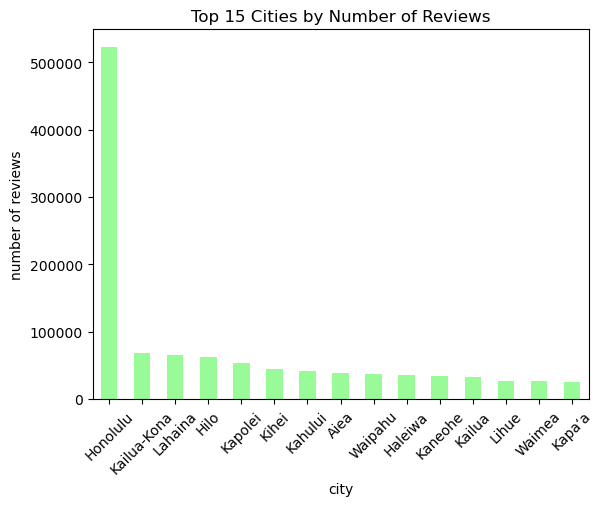

In [47]:
fig = topCities.plot(kind='bar', y='name', color='palegreen')
plt.xticks(rotation=45)
plt.title('Top 15 Cities by Number of Reviews')
plt.ylabel('number of reviews')
plt.legend().remove()

fig

In [38]:
citiesRating = hawaiiDataFrame[hawaiiDataFrame['city']\
.apply(lambda x: True if x in topCities.index else False)]\
[['city', 'rating']].groupby('city').mean()\
.sort_values(by='rating', ascending=False)
fig = px.bar(citiesRating, title='Average Rating for Top 15 Cities',
color_discrete_sequence=['goldenrod'])

fig.show()

<Axes: title={'center': 'Average Rating For Top 15 Cities'}, xlabel='city', ylabel='average rating'>

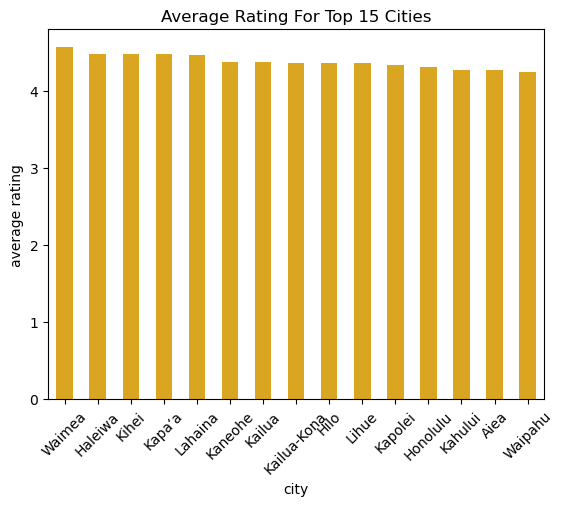

In [49]:
fig = citiesRating.plot(kind='bar', y='rating', color='goldenrod')
plt.xticks(rotation=45)
plt.title('Average Rating For Top 15 Cities')
plt.xlabel('city')
plt.ylabel('average rating')
plt.legend().remove()

fig

In [51]:
zipcodeRating = hawaiiDataFrame[['zipcode', 'rating']].groupby('zipcode')\
.mean().sort_values(by='rating', ascending=False)
fig = px.bar(zipcodeRating, title='Average Rating by Zipcode', 
color_discrete_sequence=['dodgerblue'])

fig.show()

<Axes: title={'center': 'Average Rating by Zipcode'}, xlabel='zipcode', ylabel='average rating'>

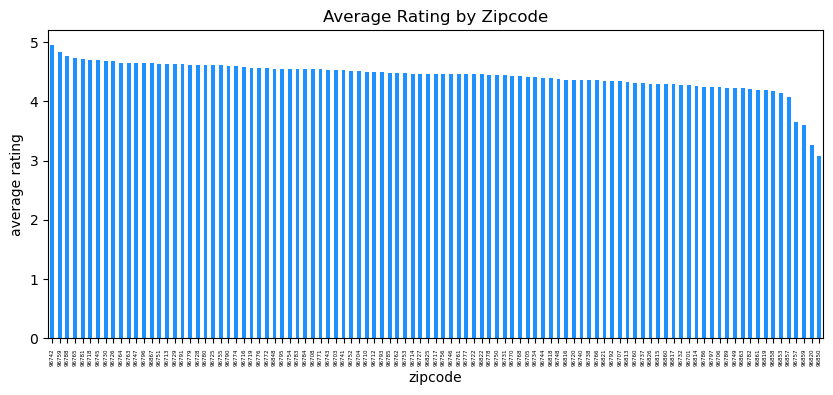

In [62]:
fig = zipcodeRating.plot(kind='bar', y='rating', color='dodgerblue', figsize=(10, 4))
plt.xticks(rotation=90, fontsize=4)
plt.title('Average Rating by Zipcode')
plt.xlabel('zipcode')
plt.ylabel('average rating')
plt.legend().remove()

fig

In [64]:
ratingOverTime = hawaiiDataFrame[['year', 'rating']].groupby('year').mean()
fig = px.scatter(ratingOverTime, title='Average Ratings Over Time', 
color_discrete_sequence=['orchid'])

fig.show()

<Axes: title={'center': 'Average Rating over Time'}, xlabel='year', ylabel='average rating'>

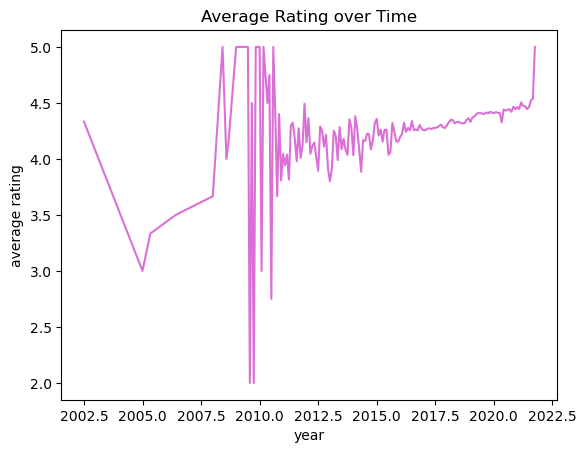

In [69]:
fig = ratingOverTime.plot(y='rating', color='orchid')
plt.title('Average Rating over Time')
plt.xlabel('year')
plt.ylabel('average rating')
plt.legend().remove()
fig

In [70]:
hawaiiTrain = allHawaii[:1200000]
hawaiiValid = allHawaii[1200000:1352173]
hawaiiTest = allHawaii[1352173:]

In [71]:
trainRatings = [d['rating'] for d in hawaiiTrain]
globalAverage = (sum(trainRatings) * 1.0) / len(trainRatings)

In [72]:
ratingsPerUser = defaultdict(list)
ratingsPerPlace = defaultdict(list)

for d in hawaiiTrain:
    u = d['user_id']
    p = d['gmap_id']
    r = d['rating']
    ratingsPerUser[u].append((p, r))
    ratingsPerPlace[p].append((u, r))

In [73]:
# Simple Linear Regression: year, average rating by zipcode, average rating.
model = LinearRegression()

X = hawaiiDataFrame[['year', 'zipcode', 'avg_rating']]
X = pd.merge(X, zipcodeRating, on='zipcode', how='left')\
.fillna(globalAverage).drop(columns=['zipcode'])

XTrain, yTrain = X.iloc[:1200000], hawaiiDataFrame.iloc[:1200000]['rating']
XValid, yValid = X[1200000:1352173], \
hawaiiDataFrame.iloc[1200000:1352173]['rating']
XTest, yTest = X[1352173:], hawaiiDataFrame.iloc[1352173:]['rating']

model.fit(XTrain, yTrain)

pred = model.predict(XTest)
predAndY = zip(pred, yTest)

lrmse = sum([(y - p) ** 2 for y, p in predAndY]) / len(pred)

print(f"Linear Regression MSE: {lrmse}")

Linear Regression MSE: 0.9027621222041154


In [74]:
# Baseline Model: Predict global Average for all Ratings.
yAndPred = [(d['rating'], globalAverage) for d in hawaiiTest]
bmmse = sum([(y - p) ** 2 for y, p in yAndPred]) / len(yAndPred)

print(f"Baseline Model MSE: {bmmse}")

Baseline Model MSE: 0.8509562841591932


In [75]:
# Latent Factor Model: alpha + betau + betai + gammau * gammai.
model = SVD()

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'gmap_id', 'rating']], reader)
lfmmse = cross_validate(SVD(), data, cv=2)['test_rmse'][0]

print(f"Latent Factor Model MSE: {lfmmse}")

Latent Factor Model MSE: 0.8131820971621532


In [76]:
# Linear Model: alpha + betau + betai.
betaU = defaultdict(float)
betaI = defaultdict(float)

for u in ratingsPerUser:
    betaU[u] = 0

for p in ratingsPerPlace:
    betaI[p] = 0

alpha = globalAverage

def iterate(lamb):
    alpha = sum([d['rating'] - (betaU[d['user_id']] + betaI[d['gmap_id']]) 
    for d in hawaiiTrain]) / len(hawaiiTrain)

    for place in ratingsPerPlace:
        betaI[place] = sum([r - (alpha + betaU[u]) 
        for u, r in ratingsPerPlace[place]]) \
        / (lamb + len(ratingsPerPlace[place]))

    for user in ratingsPerUser:
        betaU[user] = sum([r - (alpha + betaI[p]) 
        for p, r in ratingsPerUser[user]]) / (lamb + len(ratingsPerUser[user]))
    
    return alpha, betaU, betaI

lamb = 5

newAlpha, newBetaU, newBetaI = iterate(lamb)

def predict(user, game):
    score = newAlpha + newBetaU[user] + newBetaI[game]

    if score < 1:
        return 1
    
    if score > 5:
        return 5

    return score

yAndPred = [(d['rating'], predict(d['user_id'], d['gmap_id'])) 
for d in hawaiiValid]
sum([(y - p) ** 2 for y, p in yAndPred]) / len(yAndPred)

for i in range(1):

    newAlpha, newBetaU, newBetaI = iterate(lamb)
    yAndPred = [(d['rating'], predict(d['user_id'], d['gmap_id'])) 
    for d in hawaiiValid]

yAndPred = [(d['rating'], predict(d['user_id'], d['gmap_id'])) 
for d in hawaiiTest]
lmmse = sum([(y - p) ** 2 for y, p in yAndPred]) / len(yAndPred)

print(f"Linear Model MSE: {lmmse}")

Linear Model MSE: 0.6264581116074759


In [77]:
# Factorized Model: user_id, gmap_id, and zipcode.

fmdict = list(hawaiiDataFrame[['user_id', 'gmap_id', 'year']]\
.to_dict(orient='index').values())

sample = pd.read_csv('Hawaii_sample.csv')
X = pd.get_dummies(sample[['user_id', 'gmap_id', 'zipcode']]).fillna(0)
y = sample['rating']

Xtrain, ytrain = X[:12000],  y[:12000]
Xvalid, yvalid = X[12000:13500], y[12000:13500]
Xtest, ytest = X[12000:13500], y[12000:13500]

fm = xl.FMModel(task='reg', init=1, lr=0.1, reg_lamba = 1, epoch=10, 
metric='rmse')
fm.fit(Xtrain, ytrain, eval_set=[Xvalid, yvalid])

pred = fm.predict(Xtest)
predAndY = zip(pred, ytest)

fmmse = sum([(p - y) ** 2 for p, y in predAndY]) / len(pred)

print(f"Factorized Machine Model MSE: {fmmse}")

Factorized Machine Model MSE: 0.8420558700788963
